In [3]:
import networkx as nx
from pymatgen.core.structure import Structure
import os
os.chdir('/home/lucasperea/Documents/GithubRep/GraphMaterials/')
from GraphFunc.ZeoDataframeFunction import ZeoDataframe
from GraphFunc.ConexionFunction import Conexion
from pymatgen.io.cif import CifWriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from copy import deepcopy

In [343]:
from networkx.relabel import relabel_nodes
from pymatgen.core.structure import Structure
import math
import itertools
from itertools import combinations, combinations_with_replacement

In [582]:
name = 'AFX'
stu = Structure.from_file('./CifFiles/' + name + '.cif')

# Here, we have the lattice vector of the structure we want to apply PageRank algorithm
# We will use the point of applicattion of the lattice vector of the cell to locate them in space 
# once we put multiple cells togehter


# We take coodinates of the vectors A, B and C
stu.lattice

# Dimensions of the cell
box = np.array([stu.lattice.abc[0], stu.lattice.abc[1], stu.lattice.abc[2]])

# Angles of the cell's axis
alpha = stu.lattice.alpha
beta = stu.lattice.beta
gamma = stu.lattice.gamma

# Constant to change from degrees to radians
cte = math.pi/180

# Vectors proyections of the cell's vector over the ortogonal axis
x_axis = stu.lattice.a
y_axis = stu.lattice.b
z_axis = stu.lattice.c

# Cell's vectors
a, b, c = round(x_axis*math.sin(beta*cte), 3) , 0 ,round(x_axis*math.cos(beta*cte), 3)
d, e, f = round(y_axis*math.cos(gamma*cte), 3) ,round(y_axis*math.sin(gamma*cte), 3), 0
l, m, n = 0, round(z_axis*math.cos(alpha*cte), 3), round(z_axis*math.sin(alpha*cte), 3)

In [588]:
# Constant that limits the maximum number of cells that could expand over every direction 
# (axis and diagonal direction)
r = 3
        
cubic_comb = []

# Each of the cell's vectors represent the length of the cell in that direction.
# Independently of which length it is if you multiply the length of one of the vector by two it is clear
# that the result vector will give the information about the location of the second cell in the direction
# of the vector we multiply by two.

# We generate the location of the cells for a cube of length equals to len(range(-r, r + 1))
# r = 1, len(range(-r, r + 1)) = 27
# The information of location of the cells are saved in real coordinates using the combination of the 
# cell's vectors and in an orthogonal base transformation using as vectors the numbers (i,j,k) we use to multiply 
# the cell's vectors
for i in range(-r, r+1):
    for j in range(-r, r+1):
        for k in range(-r, r+1):
            cubic_comb.append((np.array([a,b,c])*i + np.array([d,e,f])*j + np.array([l,m,n])*k,
                               np.array([i,j,k])))



vector_pos = []
vector_ort = []
# Unpack values
# We also choose as a center the vector 0 
lattice_vector = stu.lattice
print('This is the Lattice vector: {}'.format(lattice_vector.abc))

# From the vector 0 we create a sphere of radius = radius_sphere
# We append all the cell that fell into the sphere
radius_sphere = min(lattice_vector.abc)#np.sqrt(np.sqrt(stu.lattice.a**2 + stu.lattice.b**2)**2 + stu.lattice.c**2)
for vec, ort in cubic_comb:
    dist_origin = np.sqrt(np.sum(np.power(vec, 2)))
    if dist_origin <= radius_sphere:
        if list(vec) in vector_pos:
            pass
        else:
            vector_pos.append(list(vec))
            vector_ort.append(list(ort))
    else:
        pass
    
len(vector_pos)

This is the Lattice vector: (13.674, 13.674, 19.695)


7

In [589]:
vector_ort # = vector_ort-np.array([1,1,1])

[[-1, -1, 0],
 [-1, 0, 0],
 [0, -1, 0],
 [0, 0, 0],
 [0, 1, 0],
 [1, 0, 0],
 [1, 1, 0]]

In [590]:
vector_pos # = vector_pos-box

[[-6.837, -11.842, 0.0],
 [-13.674, 0.0, 0.0],
 [6.837, -11.842, 0.0],
 [0.0, 0.0, 0.0],
 [-6.837, 11.842, 0.0],
 [13.674, 0.0, 0.0],
 [6.837, 11.842, 0.0]]

In [591]:
# Later in this Notebook we are going to create a graph for every vector we generated in the previous step.
# These graphs will be composed by nodes whose names will be an ordered number.
# The names will be assigned by the order the graphs were generated.
# That means every graph will have as the name of their nodes a range of numbers whose length will be equal 
# to the name of the last node we create in the first graph.
# In order to keep track of the order we create we are going to establish that order by numbered the orthogonal
# vectors

pos_order = {}
i = 0
for vector in vector_ort:
    name = str(vector[0]) + str(vector[1]) + str(vector[2]) 
    pos_order[name] = i
    i += 1
    

six_faces_neigh = [np.array([1,0,0]), np.array([-1, 0,0]), np.array([0,1,0]), 
          np.array([0,-1,0]), np.array([0,0,1]), np.array([0,0,-1])]

In [592]:
path_nt2 = './Netwrk/EDI.nt2'

In [593]:
# Initialize a networkx's graph. 
# We take the information about the nodes and edges from the .nt2 file and passes it out to the graph.

# Every node in the graph will have three attributes.
# -Cartesian coordinate
# -Pagerank coefficient
# -Radius of the maximus sphere that fit in that node

# Evey edge will have one attribute:
# -Radius of the maximus sphere that can travel through the edge

# We are not going to save the information about edges that connect point from outside of the cell

G = nx.Graph()
with open(path_nt2) as f:
    line = ' '

    while line:
        line = f.readline()

        if line == 'Vertex table:\n':
            
            while line:

                line = f.readline()
                
                if line == '\n':
                    break
                else:
                    line_list = line.split()
                    key = int(line_list[0])
                    coord_x = float(line_list[1])
                    coord_y = float(line_list[2])
                    coord_z = float(line_list[3])
                    min_dist_atom = float(line_list[4])
        
                    G.add_node(key, coord=np.array([coord_x, coord_y, coord_z]), rad_max_sph=min_dist_atom,
                              pagerank=1)

    #                 vertex_table = vertex_table.append({'coord_x':coord_x, 'coord_y':coord_y, 'coord_z':coord_z,
    #                                                     'min_dist_atom':min_dist_atom, 'key':key},ignore_index = True)


        x_1 = len(list(range(0,(sorted(list(G.nodes), reverse=True)[0] + 1))))
        
        
        
        if line == 'Edge table:\n':
            

            while line:

                line = f.readline()
                if line == '':
                    break
                line_list = line.split()
                origin = int(line_list[0])
                destination = int(line_list[2])
                larger_radius = float(line_list[3])
                x_sim = int(line_list[4])
                y_sim = int(line_list[5])
                z_sim = int(line_list[6])
                if x_sim == 8:
                    G.add_node(destination + x_1, coord=G.nodes[destination]['coord'] + np.array([box[0], 0, 0]),
                               rad_max_sph=G.nodes[destination]['rad_max_sph'], pagerank=1)
                    
                    G.add_edge(origin, destination + x_1, rad_max_sph=larger_radius)
                    print(destination + x_1)
                else:
                    if sum([abs(x_sim), abs(y_sim), abs(z_sim)]) == 0:
                        G.add_edge(origin, destination, rad_max_sph=larger_radius)
                        
                    else:
                        pass

In [594]:
# We didn't save the connection between nodes of different cells before  we are going to save it right now 
# but in a dictionary
# The information will be stored in six lists since the cell has six faces. In each list will contains the
# connections between the nodes that go through that specific face.

conx_cell = {}
x_1 = []
x_minus_1 = []
y_1 = []
y_minus_1 = []
z_1 = []
z_minus_1 = []
with open(path_nt2) as f:
    line = ' '

    while line:
        line = f.readline()
        
        if line == 'Edge table:\n':
            while line:

                line = f.readline()
                
                if line == '':
                    break
                    
                line_list = line.split()
                origin = int(line_list[0])
                destination = int(line_list[2])
                larger_radius = float(line_list[3])
                x_sim = int(line_list[4])
                y_sim = int(line_list[5])
                z_sim = int(line_list[6])
                if sum([abs(x_sim), abs(y_sim), abs(z_sim)]) == 0:
                    pass
                else:
                    if x_sim == 1:
                         x_1.append((origin,destination,larger_radius))
                    elif x_sim == -1:
                         x_minus_1.append((origin,destination,larger_radius))
                    elif y_sim == 1:
                         y_1.append((origin,destination,larger_radius))
                    elif y_sim == -1:
                         y_minus_1.append((origin,destination,larger_radius))
                    elif z_sim == 1:
                         z_1.append((origin,destination,larger_radius))
                    elif z_sim == -1:
                         z_minus_1.append((origin,destination,larger_radius))
                    else:
                        print('outside of one cell radius')

                        

conx_cell['100'] = x_1
conx_cell['-100'] = x_minus_1
conx_cell['010'] = y_1
conx_cell['0-10'] = y_minus_1
conx_cell['001'] = z_1
conx_cell['00-1'] = z_minus_1

In [595]:
# for vector in six_faces_neigh:
#     name = str(vector[0]) + str(vector[1]) +str(vector[2]) 
#     print(name)



In [596]:
# Create a dictionary which contains one graph for every cell we want to use to calculate the 
# pagerank coefficients. 
# These new graphs are a copy of the one that we initialized in previous step so, we 
# change the names and the cartesian coordinates for every node

graph_mod= {}

# As we mentioned earlier we are goint to name the nodes wit a number.
# The name of the last node of the first graph plus one (because we start in 0) will give as the range in every 
# graph.

key_plus = sorted(list(G.nodes), reverse=True)[0] + 1

# The names used as keys in the dictionary of graph are the ortogonal base transformations we calculated before
# They names are very useful to know the position of the graph with respect to the origin (0,0,0).

for i in range(len(vector_pos)):
    name = str(vector_ort[i][0])+str(vector_ort[i][1])+str(vector_ort[i][2])
    graph_mod[name] = deepcopy(G)
    
    mapping_name = {}
    multiplier = pos_order[name]
    for node in graph_mod[name].nodes:
        graph_mod[name].nodes[node]['coord'] += vector_pos[i] #*box
        mapping_name[node] = node + key_plus*multiplier
    relabel_nodes(graph_mod[name], mapping=mapping_name, copy=False)

# As you can see here it is really to see where the graph is if we now their name
print('Keys of the Dictionary of Graph: {}'.format(graph_mod.keys()))
    
    
# List with the names of the graph
cell_list = list(graph_mod.keys())

# Now we add to the graph the edges that connect with nodes outside of the cell. We do this for every graph 
# in the dictionary

for j in range(len(vector_pos)):
    for neighbor in six_faces_neigh:
        str_neighbor = str(neighbor[0]) + str(neighbor[1]) + str(neighbor[2]) 
        
        neig_loc = vector_ort[j] + neighbor
        str_neig_loc = str(neig_loc[0])+str(neig_loc[1])+str(neig_loc[2])
        
        if str_neig_loc in cell_list:
            name = str(vector_ort[j][0])+str(vector_ort[j][1])+str(vector_ort[j][2])
            multiplier_origin = pos_order[name]
            multiplier_destination = pos_order[str_neig_loc]
            
            for edge in conx_cell[str_neighbor]:
                edge_1 = edge[0] + multiplier_origin*key_plus
                edge_2 = edge[1] + multiplier_destination*key_plus
                rad_max_sph = edge[2]
                graph_mod[name].add_edge(edge_1, edge_2)
                graph_mod[name].edges[edge_1, edge_2]['rad_max_sph'] = rad_max_sph
            
            
# for key in graph_mod:
#     print(key, len(graph_mod[key].nodes))

Keys of the Dictionary of Graph: dict_keys(['-1-10', '-100', '0-10', '000', '010', '100', '110'])


In [597]:
# Here, we create a final graph and we store in it the information of all the nodes and edges of the ones
# we generate in the previous step
final = nx.Graph()

for key in graph_mod:
    final.add_nodes_from(graph_mod[key])
    final.add_edges_from(graph_mod[key].edges)
    for node in graph_mod[key].nodes:
        for attr in graph_mod[key].nodes[node]:
            final.nodes[node][attr] = graph_mod[key].nodes[node][attr]
        
    for edge in graph_mod[key].edges:
        for attr in graph_mod[key].edges[edge[0], edge[1]]:
            final.edges[edge][attr] = graph_mod[key].edges[edge][attr] 
  

In [598]:
# We calculate the neighbors for every node in the graph
neigh_dic = {}
for n, nbrs in final.adj.items():
    neigh = []
    for nbr, eattr in nbrs.items():
        neigh.append(nbr)
        
        
    neigh_dic[str(n)] = neigh

In [599]:
# For every node we calculate the sum of the square radius of their edges
sum_radius = {}
for node in final.nodes:
    
    sum_edges = 0
    for nei in neigh_dic[str(node)]:
        
        score = final[node][nei]['rad_max_sph']
        sum_edges += score**2
    sum_radius[str(node)] = sum_edges

In [600]:
#  conexion is a dictionary that saves information of the weights that every edge has in 
# relationship with the total number of edges in the node.
# Every edge has a radius as attribute so we are using the proportion of the square of the radius divide by
# the sum of the square radius in the node

conexion = {}
sub = {}
for node in final.nodes:
    
    sub = {}
    for nei in neigh_dic[str(node)]:
        radius_node = final[node][nei]['rad_max_sph']
        all_radius = sum_radius[str(nei)] 
        sub[str(nei)] = radius_node**2/all_radius
    conexion[str(node)] = sub
       

In [601]:
# for node in final.nodes:
#     print(sum(conexion[str(node)].values()))

In [602]:
# sum_edges = 0
# for nei in neigh_dic['0']:
#     print(nei)
#     score = final[0][nei]['rad_max_sph']
#     sum_edges += score
# sum_edges

In [603]:
# Loop over the number of iterations we want to run pagerank
def pagerank(graph, iteration, conexion, neigh_dic):
        for i in range(iteration):
            last = pagerank_one_iter(graph, conexion, neigh_dic)
        return(last)
    
# Loop over the nodes of the graph
def pagerank_one_iter(graph, conexion, neigh_dic):
    node_list = sorted(list(graph.nodes))
    for node in node_list:
        update_pagerank(node, conexion, neigh_dic, graph)
#         graph.normalize_pagerank()
    pagerank_list = np.asarray([graph.nodes[node]['pagerank'] for node in node_list], dtype='float32')
    return pagerank_list

# Update of the nodes attribute pagerank following the rule we describe in connections
def update_pagerank(selfnode, conexion, neigh_dic, graph):
    in_neighbors = neigh_dic[str(selfnode)] #self.parents
#     print(in_neighbors, selfnode)
    pagerank_sum = sum(graph.nodes[node]['pagerank']*conexion[str(selfnode)][str(node)]
                       for node in in_neighbors)
#     print(selfnode)
    graph.nodes[selfnode]['pagerank'] = pagerank_sum
    
    
info = pagerank(final, 50, conexion, neigh_dic)

In [604]:
info[np.argsort(info)[-1:-len(vector_pos)-1:-1]]

array([6.028894 , 6.0037737, 5.993153 , 5.9163465, 5.9079533, 5.884254 ,
       5.8469353], dtype=float32)

In [605]:
info[np.argsort(info)[-1:-len(vector_pos)-2:-1]]

array([6.028894 , 6.0037737, 5.993153 , 5.9163465, 5.9079533, 5.884254 ,
       5.8469353, 3.5236602], dtype=float32)

In [606]:
most_conn_nod = np.argsort(info)[-1:-len(vector_pos)-1:-1]

node_list = sorted(list(final.nodes))
pagerank_nodes = np.zeros((len(info[most_conn_nod]),3))
i = 0
for pos in most_conn_nod:

    
    pagerank_nodes[i,:] = final.nodes[node_list[pos]]['coord']
    i += 1

<IPython.core.display.Javascript object>


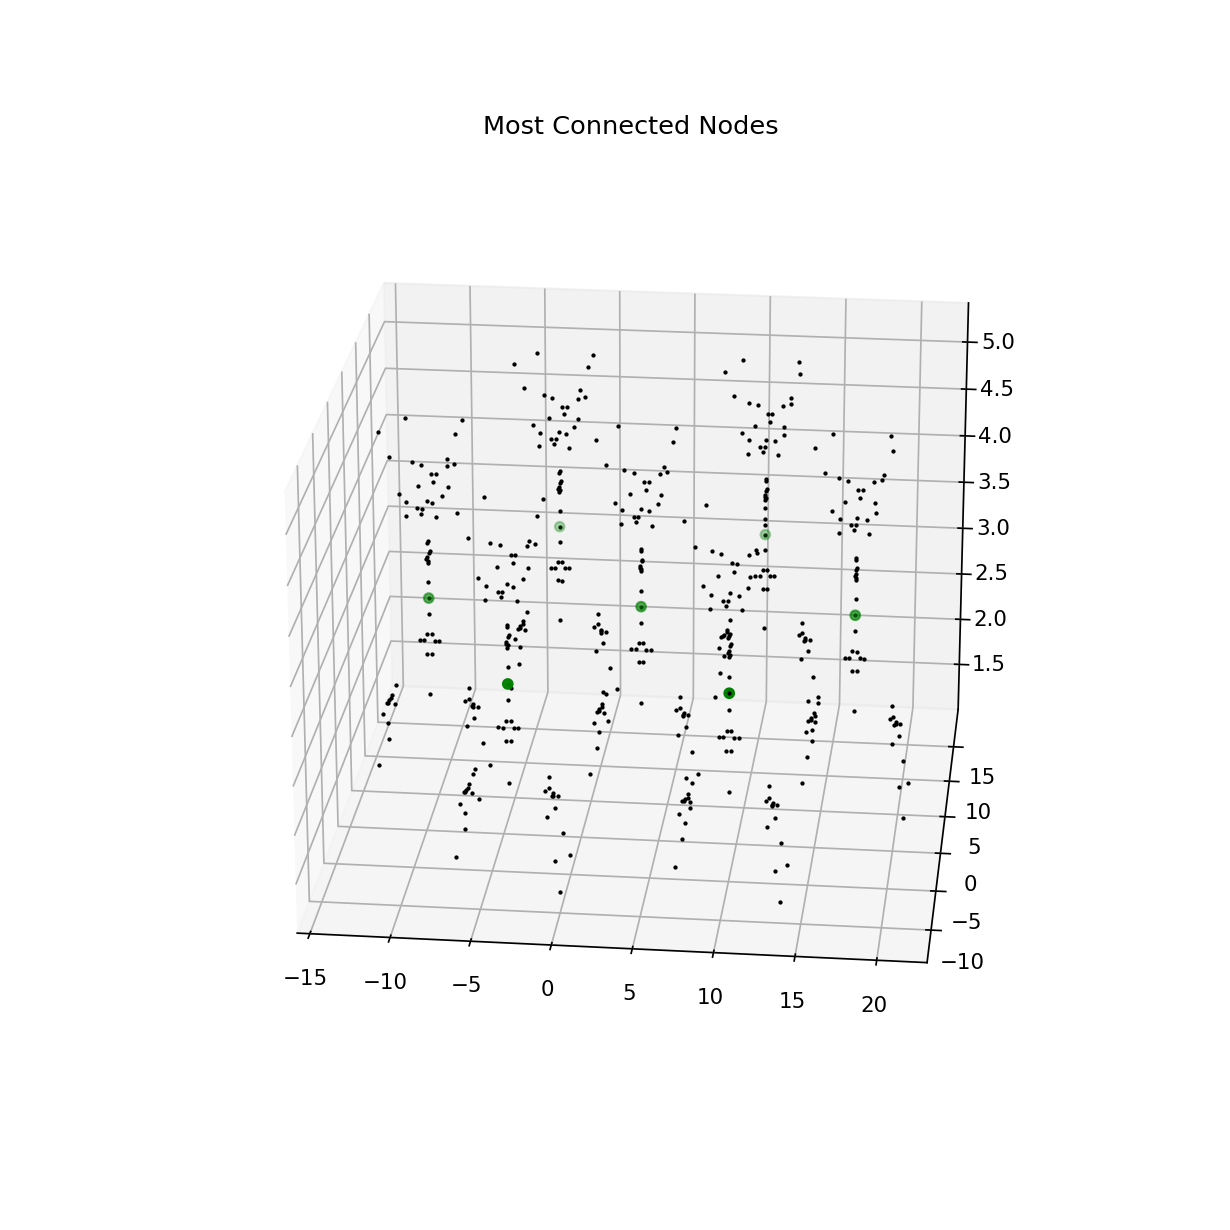

In [609]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

plt.title('Most Connected Nodes')


ax.scatter(pagerank_nodes[:,0], pagerank_nodes[:,1], pagerank_nodes[:,2], s=20, c='green')   

for node in final.nodes:
    
    ax.scatter(final.nodes[node]['coord'][0], final.nodes[node]['coord'][1], final.nodes[node]['coord'][2], 
               s=1, c='black')

# ax.scatter(pagerank_nodes[:,0], pagerank_nodes[:,1], pagerank_nodes[:,2], s=20, c='green')
ax.figure.savefig('./result/most')

In [188]:
info[np.argsort(info)[-1:-8:-1]]
len(info)
node_list = sorted(list(final.nodes))
pagerank_nodes = np.zeros((7,3))
i = 0
for pos in np.argsort(info)[-1:-8:-1]:
#     print(node_list[pos])
    print(final.nodes[node_list[pos]]['coord'])
    pagerank_nodes[i,:] = final.nodes[node_list[pos]]['coord']
    i += 1

[ 3.463 -3.463  3.205]
[3.463 3.463 9.615]
[10.389  3.463  3.205]
[3.463 3.463 3.205]
[-3.463  3.463  3.205]
[ 3.463  3.463 -3.205]
[ 3.463 10.389  3.205]


In [189]:
pagerank_nodes

array([[ 3.463, -3.463,  3.205],
       [ 3.463,  3.463,  9.615],
       [10.389,  3.463,  3.205],
       [ 3.463,  3.463,  3.205],
       [-3.463,  3.463,  3.205],
       [ 3.463,  3.463, -3.205],
       [ 3.463, 10.389,  3.205]])

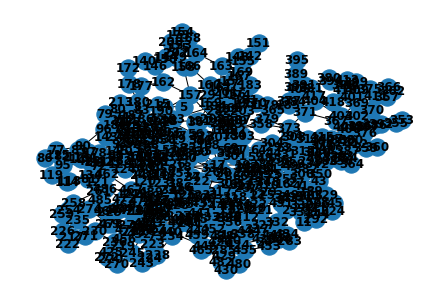

In [87]:
nx.draw(final, with_labels=True, font_weight='bold')

In [ ]:

for node in H.nodes:
    for attr in H.nodes[node]:
        G.nodes[node][attr] = H.nodes[node][attr]
        
for edge in H.edges:
    for attr in H.edges[edge[0], edge[1]]:
        G.edges[edge][attr] = H.edges[edge][attr]    

In [26]:
conx_cell = {}
x_1 = []
x_minus_1 = []
y_1 = []
y_minus_1 = []
z_1 = []
z_minus_1 = []
with open(path_nt2) as f:
    line = ' '

    while line:
        line = f.readline()
        
        if line == 'Edge table:\n':
            while line:

                line = f.readline()
                
                if line == '':
                    break
                    
                line_list = line.split()
                origin = int(line_list[0])
                destination = int(line_list[2])
                larger_radius = float(line_list[3])
                x_sim = int(line_list[4])
                y_sim = int(line_list[5])
                z_sim = int(line_list[6])
                if sum([abs(x_sim), abs(y_sim), abs(z_sim)]) == 0:
                    pass
                else:
                    if x_sim == 1:
                         x_1.append((origin,destination,larger_radius))
                    elif x_sim == -1:
                         x_minus_1.append((origin,destination,larger_radius))
                    elif y_sim == 1:
                         y_1.append((origin,destination,larger_radius))
                    elif y_sim == -1:
                         y_minus_1.append((origin,destination,larger_radius))
                    elif z_sim == 1:
                         z_1.append((origin,destination,larger_radius))
                    elif z_sim == -1:
                         z_minus_1.append((origin,destination,larger_radius))
                        
conx_cell['100'] = x_1
conx_cell['-100'] = x_minus_1
conx_cell['010'] = y_1
conx_cell['0-10'] = y_minus_1
conx_cell['001'] = z_1
conx_cell['00-1'] = z_minus_1

In [114]:
for key in conx_cell:
    print(len(conx_cell[key]))

10
10
10
10
13
13


In [112]:
x_minus_1

[(10, 3, 0.0922282),
 (14, 5, 0.0922282),
 (28, 56, 0.78061),
 (33, 58, 1.10205),
 (35, 57, 1.39808),
 (60, 65, 1.10205),
 (62, 66, 0.78061),
 (67, 67, 0.429155),
 (68, 68, 0.759739),
 (69, 69, 0.429154)]

In [22]:
L = nx.Graph()

In [25]:
L.add_edge(1,0)
L.edges[(1,0)]['weight'] = 5

In [72]:
L.edges

EdgeView([(1, 2)])

In [193]:
pagerank_nodes.shape

(7, 3)

In [74]:
L.add_edge(2,1, weight=0.6)

<IPython.core.display.Javascript object>


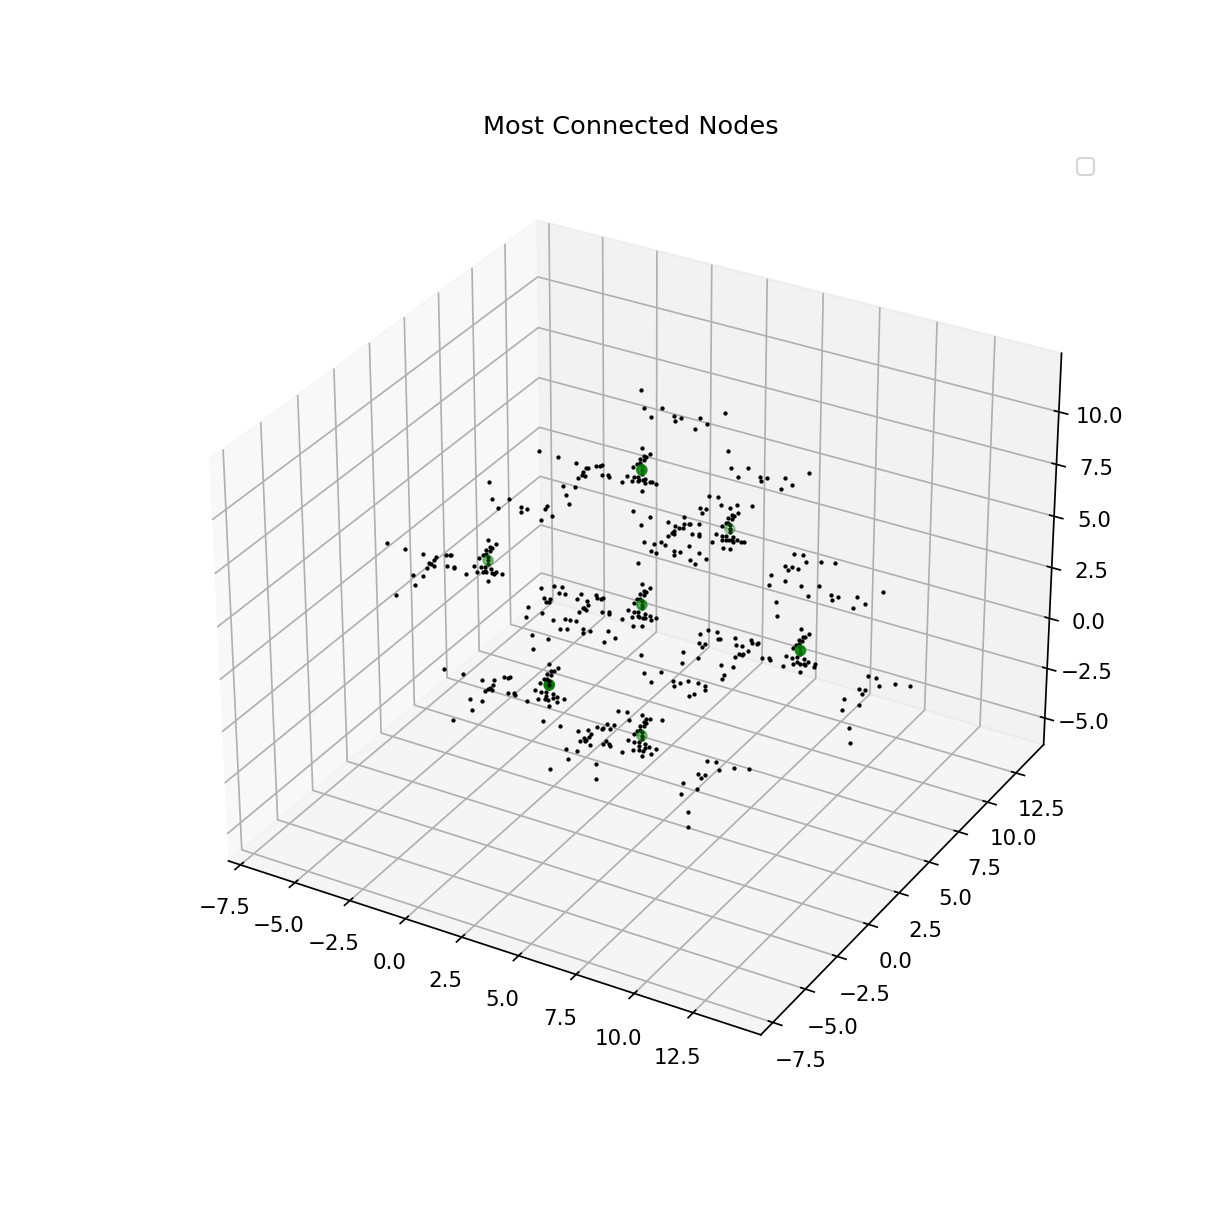

In [276]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

plt.title('Most Connected Nodes')
plt.legend(labels=[1,2])
# for node in final.nodes:
    
#     ax.scatter(final.nodes[node]['coord'][0], final.nodes[node]['coord'][1], final.nodes[node]['coord'][2], 
#                s=1, c='black')
ax.scatter(pagerank_nodes[:,0], pagerank_nodes[:,1], pagerank_nodes[:,2], s=20, c='green')    
for node in final.nodes:
    
    ax.scatter(final.nodes[node]['coord'][0], final.nodes[node]['coord'][1], final.nodes[node]['coord'][2], 
               s=1, c='black')

# ax.scatter(pagerank_nodes[:,0], pagerank_nodes[:,1], pagerank_nodes[:,2], s=20, c='green')
ax.figure.savefig('./result/most')

In [186]:
final.nodes[node]['coord']

array([3.31303, 3.463  , 2.62059])